In [1]:
import connector
from datetime import datetime, date
from lifelines.utils import datetimes_to_durations
import numpy as np
from lifelines import NelsonAalenFitter
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Background
- importing data
- cleaning data
- descriptive statistics

In [84]:
# get data from google sheet, then deal with google sheet's ridiculous data type issues
df = pd.DataFrame(connector.SheetConn('cohort_trial_data').sheet1.get_all_records())

#manually parsing string dates because gspread dtypes suck
sheets_date_format = '%Y-%m-%d %H:%M:%S'
df['start_dt'] = df['start_dt'].apply(lambda x: datetime.strptime(x, sheets_date_format))
df['completion_dt'] = df['completion_dt'].apply(lambda x: datetime.strptime(x, sheets_date_format) if x!='' else None)
df.drop('', axis=1, inplace=True)
#define cohorts by the day in which the user signed up for a trial
# this is often desirable for survival analysis since 
df['cohort'] = df['start_dt'].map(lambda x: x.day)

#use the lifelines datetimes_to_durations function for a observed (boolean) column and a duration (time it took to subscribe)
df['duration'], df['observed'] = datetimes_to_durations(df['start_dt']\
            , df['completion_dt'], fill_date='2019-04-01')

df = df[df.cohort!=3]
df['device'].replace('', np.NaN, inplace=True)
df['browser'].replace('', np.NaN, inplace=True)

df[['id', 'device', 'browser', 'start_dt', 'cohort', 'completion_dt', 'observed', 'duration']].head()

,id,device,browser,start_dt,cohort,completion_dt,observed,duration
0,51809381e4b03c6b86a6256f,desktop,chrome,2018-07-15,15,2018-07-28 23:00:00,True,13.0
1,518093ade4b00cbd5d9abe26,desktop,firefox,2018-07-15,15,NaT,False,260.0
2,518093d6e4b0c1fda9c05d54,desktop,ie,2018-07-15,15,2018-07-29 20:00:00,True,14.0
3,518093f2e4b0b0f0caf55867,desktop,firefox,2018-07-15,15,NaT,False,260.0
4,518093fee4b01eeb7aec8bfc,desktop,chrome,2018-07-15,15,NaT,False,260.0


### cleaning

In [ ]:
#any weird data out there?
df[df.start_dt>df.completion_dt]

In [ ]:
df[(df.observed==True)&(pd.isnull(df.completion_dt))]

In [ ]:
df[(df.observed==False)&(pd.notnull(df.completion_dt))]

In [ ]:
df.isnull().sum()/len(df)

In [ ]:
df['id'].value_counts().nlargest(5)

In [39]:
#not always this easy but since the rows are the same this is fine
df.drop_duplicates(subset='id', inplace=True)

### descriptive stats

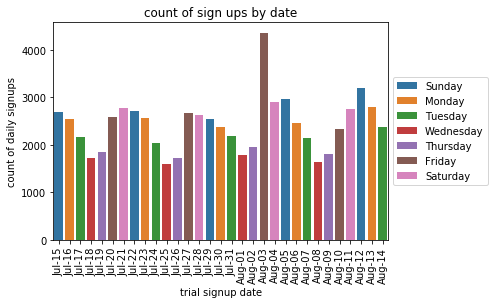

In [3]:
'''
there is weekly seasonality in signups- ther are more isgnups on the weekends and fewer on the weekdays. This is either a b
to c product or our users are a bunch of workaholics. 
'''
ax = sns.barplot(
    x='date_label'
    ,y='id'
    ,hue='dow'
    ,data=df.groupby(pd.Grouper(key='start_dt', freq='1d'))['id'].nunique().reset_index()\
            .assign(dow= lambda df_: df_['start_dt'].apply(lambda x: x.weekday_name))\
            .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    ,dodge=False
)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('count of sign ups by date')

ax.set_xlabel('trial signup date')
ax.set_ylabel('count of daily signups')

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

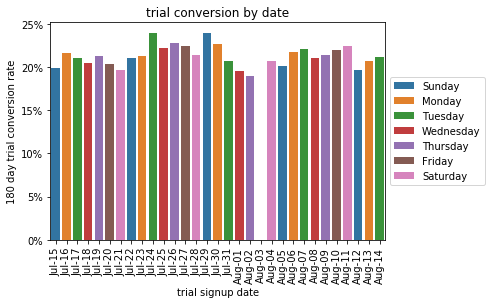

In [18]:
'''
conversion rate does not exhibit the same seasonality as frequency of signups. there might be some pattern at the hourly level but
let's not complicate things before we have to
'''

ax = sns.barplot(
    x='date_label'
    ,y='observed'
    ,hue='dow'
    ,data=df.groupby(pd.Grouper(key='start_dt', freq='1d'))['observed'].mean().reset_index()\
            .assign(dow= lambda df_: df_['start_dt'].apply(lambda x: x.weekday_name))\
            .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    ,dodge=False
)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('trial conversion by date')

ax.set_xlabel('trial signup date')
ax.set_ylabel('180 day trial conversion rate')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

Text(0, 0.5, 'count of trials started')

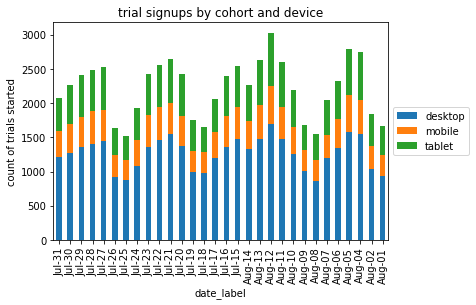

In [19]:
'''
most trials appear to be started on desktop. We could perform some cool statistical tests to see if the makeup of
device changes over this time period but there's no intiutive reason why it should and it certaintly doesn't appear 
to be an issue just by eyeballing the chart. let's move on to more exiciting things
'''
ax = pd.pivot_table(
    df\
    .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    .groupby(['date_label', 'device'])['id'].count().reset_index()
    ,index='date_label'
    ,columns='device'
).sort_index(ascending=False).T.droplevel(0).T.plot(kind='bar', stacked=True)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('trial signups by cohort and device')

ax.set_ylabel('count of trials started')

[Text(0, 0, '0%'),
 Text(0, 0, '20%'),
 Text(0, 0, '40%'),
 Text(0, 0, '60%'),
 Text(0, 0, '80%'),
 Text(0, 0, '100%'),
 Text(0, 0, '120%')]

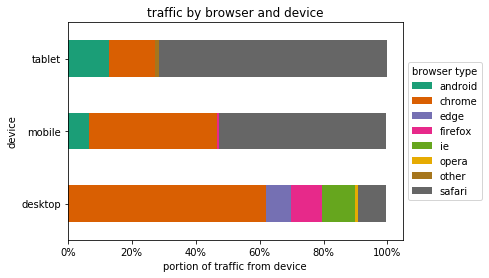

In [21]:
'''
just checking to see if something looks off about this
'''
ax = df.groupby(['browser','device']).size().unstack()\
    .div(df.groupby(['device']).size()).T\
.plot(kind='barh', stacked=True, colormap='Dark2')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='browser type')
ax.set_title('traffic by browser and device')

ax.set_xlabel('portion of traffic from device')
ax.set_ylabel('device')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])

In [22]:
'''
using scipy's chi squared test to see if the differences in conversion in devices are significant. They appear to be from our plot but it
(usually) can't hurt to check
'''

from scipy.stats import chi2_contingency
from scipy.stats import chi2
stat, p, dof, expected = chi2_contingency(\
                    df.groupby(['device', 'observed']).size().unstack())
stat, chi2.ppf(0.95, dof), abs(stat) >= chi2.ppf(0.95, dof), p<0.05

(1166.7631378867577, 5.991464547107979, True, True)

In [23]:
'''
while trials started on different devices convert at significantly different rates, the browser type does not
'''
chi_squared_results_browser = {}
for device in df.device.dropna().unique():
    stat, p, dof, expected = chi2_contingency(\
                    df[df.device==device].groupby(['browser', 'observed']).size().unstack())
    chi_squared_results_browser[device] = {'stat': stat, 'ppf': chi2.ppf(0.95, dof), 'is_significant': p<0.05}
pd.DataFrame(chi_squared_results_browser).T

,is_significant,ppf,stat
desktop,False,11.0705,7.35352
mobile,False,7.81473,0.547923
tablet,False,7.81473,1.54487


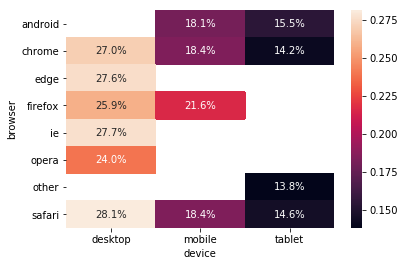

In [25]:
'''
a really ugly heatmap showing conversion by device and browser
'''
sns.heatmap(df[df.observed==True].groupby(['browser','device']).size().unstack()/\
df.groupby(['browser','device']).size().unstack(), annot=True, fmt=".1%")

### Conversion

[Text(0, 0, '4%'),
 Text(0, 0, '6%'),
 Text(0, 0, '8%'),
 Text(0, 0, '10%'),
 Text(0, 0, '12%'),
 Text(0, 0, '14%'),
 Text(0, 0, '16%'),
 Text(0, 0, '18%'),
 Text(0, 0, '20%'),
 Text(0, 0, '22%'),
 Text(0, 0, '24%')]

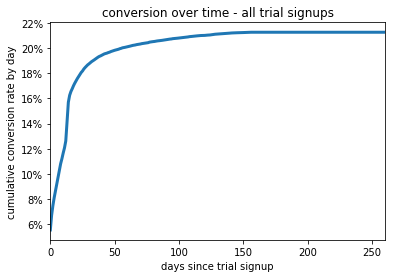

In [26]:
ax = (df.groupby(['duration'])['observed'].sum().cumsum()/len(df)).plot(linewidth=3)
ax.set_title('conversion over time - all trial signups')
ax.set_ylabel('cumulative conversion rate by day')
ax.set_xlabel('days since trial signup')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])

Text(0, 0.5, '% converted')

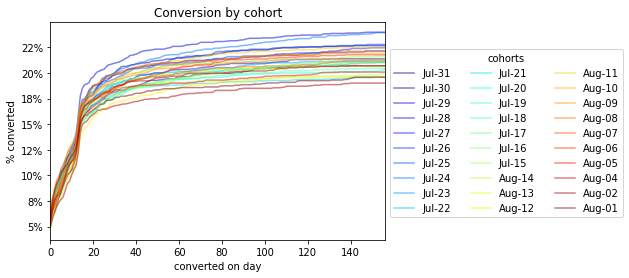

In [28]:
ax = pd.pivot_table(
    df[df.observed==True]\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    .groupby(['date_label', 'duration'])['id'].count().reset_index()
    ,columns='date_label'
    ,index='duration'
).fillna(0).cumsum().T.droplevel(level=0).T.div(
    df\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))\
        .groupby(['date_label'])['id'].count().T).sort_index(ascending=False, axis=1)\
.plot(colormap='jet', alpha=0.5)

ax.legend(loc=0, ncol=3, bbox_to_anchor=(1.0, 0.9), title='cohorts')
ax.set_title('Conversion by cohort')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('converted on day')
ax.set_ylabel('% converted')

Text(0.5, 0, 'conversion rate')

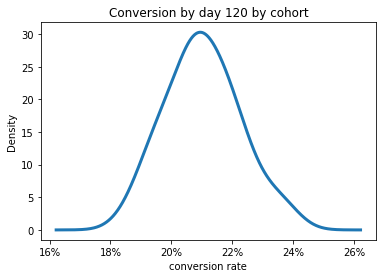

In [29]:
ax = pd.pivot_table(
    df[df.observed==True]\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    .groupby(['date_label', 'duration'])['id'].count().reset_index()
    ,columns='date_label'
    ,index='duration'
).fillna(0).cumsum().T.droplevel(level=0).T.div(
    df\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))\
        .groupby(['date_label'])['id'].count().T).sort_index(ascending=False, axis=1).loc[120]\
.plot(kind='density', linewidth=3)

ax.set_title('Conversion by day 120 by cohort')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('conversion rate')

Text(0, 0.5, '% converted')

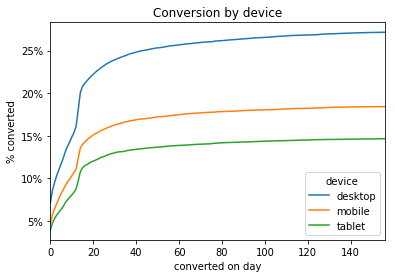

In [30]:
ax = pd.pivot_table(
    df[df.observed==True]\
        .groupby(['device', 'duration'])['id'].count().reset_index()
    ,index='device'
    ,columns='duration'
).T.fillna(0).droplevel(level=0).cumsum().div(df.groupby(['device'])['id'].count()).plot()

ax.set_title('Conversion by device')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('converted on day')
ax.set_ylabel('% converted')

Text(0, 0.5, 'cumulative conversions')

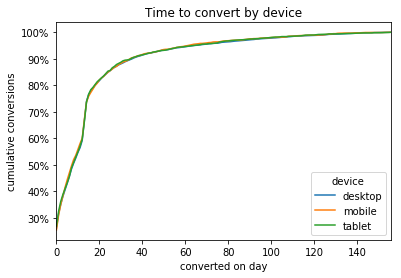

In [31]:
'''
While the groups differ significantly in terms of eventual trial conversion, they appear to all follow the same trajectory
to their eventual conversion rate. Another way to say this is that each group's conversion rate remains _proportional_ to 
one another. 
'''

ax = pd.pivot_table(
    df[df.observed==True]\
        .groupby(['device', 'duration'])['id'].count().reset_index()
    ,index='device'
    ,columns='duration').T.fillna(0).droplevel(level=0).cumsum().div(df[df.observed==True].groupby(['device'])['id'].count()).plot()

ax.set_title('Time to convert by device')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('converted on day')
ax.set_ylabel('cumulative conversions')

Text(0.5, 0, 'conversion rate at day 120')

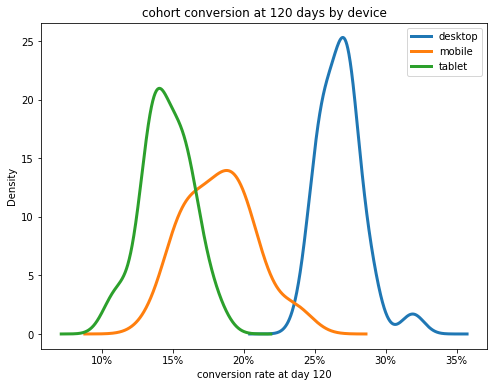

In [32]:
'''
another way to see the huge differences by device
'''
fig, ax = plt.subplots(figsize=(8,6))

pd.pivot_table(
    df[df.observed==True]\
        .groupby(['cohort', 'device', 'duration'])['id'].count().groupby(level=[0,1]).cumsum().reset_index()
    ,index='duration'
    ,columns=['cohort', 'device']
    ,values='id'
)\
    .ffill().loc[120]\
    .div(df.groupby(['cohort', 'device'])['id'].count())\
    .groupby('device', level=1)\
    .plot(ax=ax, kind='density', linewidth=3, legend=True)

ax.set_title('cohort conversion at 120 days by device')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('conversion rate at day 120')

Text(0.5, 1.0, 'eventual conversion rate baseline: simple device adjustements')

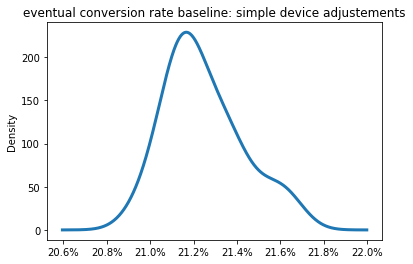

In [34]:
device_conversion = df.groupby('device')['observed'].mean().to_dict()
ax = pd.concat([
    df[df.device=='desktop'].groupby('cohort')['id'].count().apply(lambda x: x*device_conversion['desktop']).rename('desktop')
    ,df[df.device=='mobile'].groupby('cohort')['id'].count().apply(lambda x: x*device_conversion['mobile']).rename('mobile')
    ,df[df.device=='tablet'].groupby('cohort')['id'].count().apply(lambda x: x*device_conversion['tablet']).rename('desktop')
], axis=1).sum(axis=1).div(df.groupby('cohort')['id'].count()).plot(kind='density', linewidth=3)


ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_title('eventual conversion rate baseline: simple device adjustements')


### Regression
we need a way to adjust our estimates for device types. This assumes we don't anticipate any changes to the makeup of device types (i.e. a mobile app would definitely violate this) but it's a start

#### CPH

In [35]:
def create_regression_df(df, dummy_cols, dummy_to_drop='mobile', split=False, prefix='device'):
    regression_df = pd.concat([
        df.drop(dummy_cols, axis=1)
        ,pd.get_dummies(df[dummy_cols]\
                        ,dummy_na=False, prefix=prefix, drop_first=False)
    ], axis=1)\
    .drop('{}_{}'.format(prefix, dummy_to_drop), axis=1)
    
    if split==True:
        X_train, X_test = train_test_split(regression_df, test_size=0.33)
        return X_train, X_test
    return regression_df

In [40]:
X_train, X_test = create_regression_df(
                          df[(pd.notnull(df.device))].set_index(['cohort', 'id'])\
                            [['observed', 'duration', 'device']]\
                          ,dummy_cols=['device']\
                          ,split=True)
X_train[X_train.duration==120].head()

,,observed,duration,device_desktop,device_tablet
cohort,id,,,,


<lifelines.CoxPHFitter: fitted with 44640 observations, 34592 censored>
      duration col = 'duration'
         event col = 'observed'
number of subjects = 44640
  number of events = 10048
    log-likelihood = -105960.96
  time fit was run = 2019-04-24 19:33:28 UTC

---
                coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
device_desktop  0.42      1.52      0.03 14.78 <0.005    161.71        0.36        0.47
device_tablet  -0.27      0.76      0.04 -7.56 <0.005     44.55       -0.34       -0.20
---
Concordance = 0.57
Log-likelihood ratio test = 780.32 on 2 df, -log2(p)=562.88


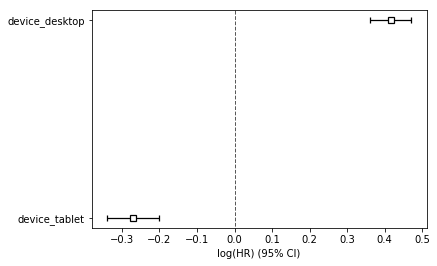

In [41]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(X_train, duration_col='duration', event_col='observed')
cph.print_summary()
cph.plot()

In [42]:
cph.check_assumptions(X_train, p_value_threshold=0.05, show_plots=False)

Proportional hazard assumption looks okay.


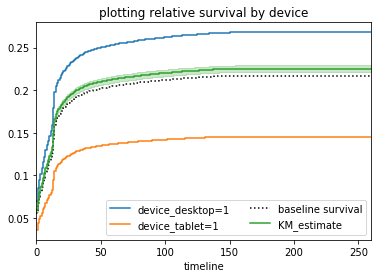

In [43]:
#plotting 1 - survival curve. This is more intuitive way to think about it and converting from hazards to survival sucks
ax = cph.plot_covariate_groups(['device_desktop', 'device_tablet'], values=np.eye(2))

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(X_train['duration'], event_observed=X_train['observed'])
ax = kmf.plot(ax=ax, invert_y_axis=True)
ax.set_title('plotting relative survival by device')
ax.legend(loc=4, ncol=2)

### AAF

<lifelines.AalenAdditiveFitter: fitted with 44640 observations, 34592 censored>
      duration col = 'duration'
         event col = 'observed'
    coef penalizer = '1.0'
number of subjects = 44640
  number of events = 10048
  time fit was run = 2019-04-24 19:33:43 UTC

---
                slope(coef)  se(slope(coef))
device_desktop         0.00             0.02
device_tablet         -0.00             0.01
_intercept             0.00             0.04
---
Concordance = 0.57


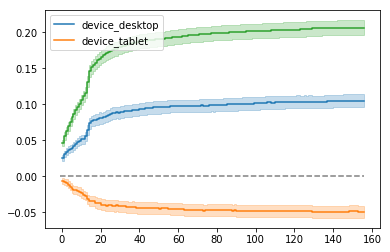

In [44]:
from lifelines import AalenAdditiveFitter

aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=True)
aaf.fit(X_train, 'duration', event_col='observed')
aaf.print_summary()
aaf.cumulative_hazards_.head()
aaf.plot()

Text(0, 0.5, '% converted')

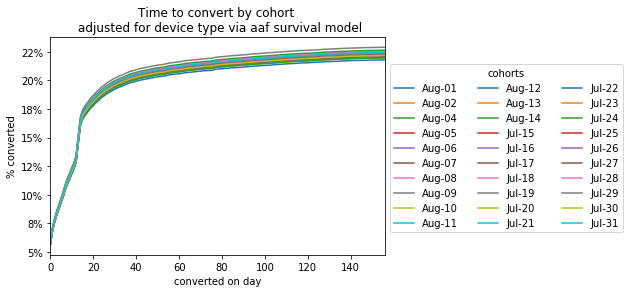

In [45]:
ax = pd.concat([
    aaf.predict_survival_function(X_test.droplevel(level=[0])).T.apply(lambda x: 1-x)
    ,df[df.id.isin(X_test.index.levels[1])].reset_index().set_index('id')['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')).rename('cohort')
], axis=1, join='inner').groupby('cohort').mean().T.plot()

ax.legend(loc=0, ncol=3, bbox_to_anchor=(1.0, 0.9), title='cohorts')
ax.set_title('Time to convert by cohort \n adjusted for device type via aaf survival model')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('converted on day')
ax.set_ylabel('% converted')

Text(0, 0.5, '% converted')

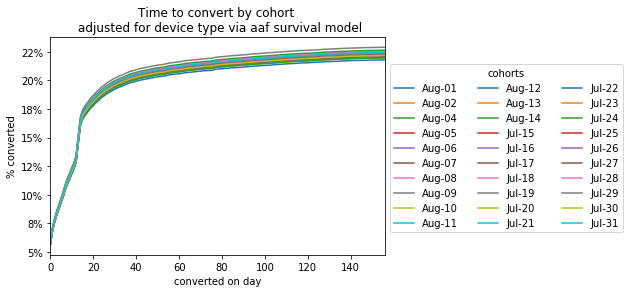

In [46]:
ax = pd.concat([
    aaf.predict_survival_function(X_test.droplevel(level=[0])).T.apply(lambda x: 1-x)
    ,df[df.id.isin(X_test.index.levels[1])].reset_index().set_index('id')['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')).rename('cohort')
], axis=1, join='inner').groupby('cohort').mean().T.plot()

ax.legend(loc=0, ncol=3, bbox_to_anchor=(1.0, 0.9), title='cohorts')
ax.set_title('Time to convert by cohort \n adjusted for device type via aaf survival model')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('converted on day')
ax.set_ylabel('% converted')



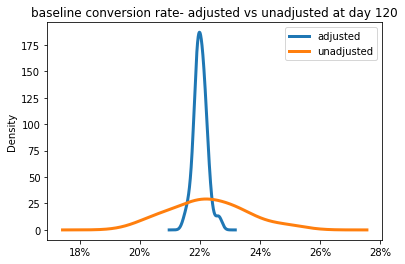

In [53]:
'''
same mean, just way less variance
'''
ax = pd.concat([
    cph.predict_survival_function(X_test.droplevel(level=[0])).T.apply(lambda x: 1-x)
    ,df[df.id.isin(X_test.index.levels[1])].reset_index().set_index('id')['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')).rename('cohort')
], axis=1, join='inner').groupby('cohort').mean()[121].plot(kind='density', linewidth=3, label='adjusted')

pd.pivot_table(
    df[(df.observed==True)&(df['id'].isin(X_test.index.levels[1]))]\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    .groupby(['date_label', 'duration'])['id'].count().reset_index()
    ,columns='date_label'
    ,index='duration'
).fillna(0).cumsum().T.droplevel(level=0).T.div(
    df[(df['id'].isin(X_test.index.levels[1]))]\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))\
        .groupby(['date_label'])['id'].count().T).sort_index(ascending=False, axis=1).loc[121]\
    .plot(ax=ax, kind='density', linewidth=3, label='unadjusted')


ax.set_title('baseline conversion rate- adjusted vs unadjusted at day 120')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.legend()



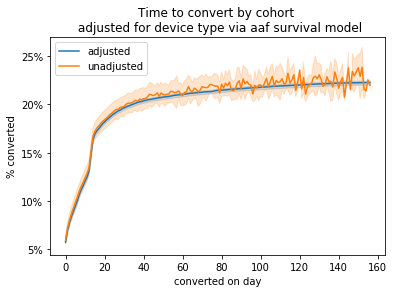

In [55]:
ax = sns.lineplot(
    data=pd.melt(
            pd.concat([
                aaf.predict_survival_function(X_test.droplevel(level=[0])).T.apply(lambda x: 1-x)
                ,df[df.id.isin(X_test.index.levels[1])].reset_index()\
                    .set_index('id')['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')).rename('cohort')
            ], axis=1, join='inner').groupby('cohort').mean().reset_index()
        ,id_vars='cohort'
        ,value_name='survival'
        ,var_name='duration'
        )
    ,x='duration'
    ,y='survival'
    ,ci='sd'
    ,label='adjusted'
)


sns.lineplot(
    data = (df[(df.observed==True)&(df.id.isin(X_test.index.levels[1]))]\
        .groupby(['cohort', 'duration'])['id'].count().groupby(level=[0]).cumsum()/\
        df[(df.id.isin(X_test.index.levels[1]))].groupby(['cohort'])['id'].count()).reset_index()
    ,x='duration'
    ,y='id'
    ,ci='sd'
    ,ax=ax
    ,label='unadjusted'
)

ax.set_title('Time to convert by cohort \n adjusted for device type via aaf survival model')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('converted on day')
ax.set_ylabel('% converted')
ax.legend()

# Impact of previous product launches

Text(0, 0.5, 'conversion rate')

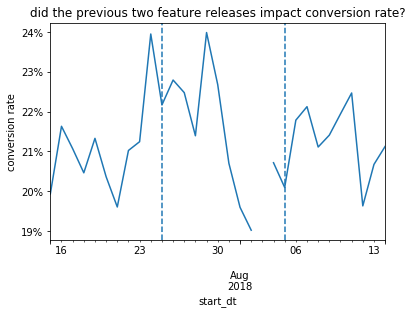

In [56]:
date_of_feature_a = date(2018,7,23)
date_of_feature_b = date(2018,8,5)

ax = df.groupby(pd.Grouper(key='start_dt', freq='1d'))['observed'].mean().plot()
ax.axvline(date(2018,7,25), linestyle='--')

ax.axvline(date(2018,8,5), linestyle='--')

ax.set_title('did the previous two feature releases impact conversion rate?')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_ylabel('conversion rate')

In [57]:
previous_feature_cols = ['feature_a_treatment', 'feature_b_treatment', 'feature_a_control', 'feature_b_control']

X_train, X_test = create_regression_df(
                df[(pd.notnull(df.device))].set_index(['cohort', 'id'])\
                    .assign(feature_a_treatment=lambda df_: df_['start_dt']
                                .apply(lambda x: 0<(datetime.date(x)-date_of_feature_a).days<=7))
                    .assign(feature_b_treatment=lambda df_: df_['start_dt']
                                .apply(lambda x: -7<=(datetime.date(x)-date_of_feature_a).days<0))
                    .assign(feature_a_control=lambda df_: df_['start_dt']
                                .apply(lambda x: 0<(datetime.date(x)-date_of_feature_b).days<=7))
                    .assign(feature_b_control=lambda df_: df_['start_dt']
                                .apply(lambda x: -7<=(datetime.date(x)-date_of_feature_b).days<0))
                    [['observed', 'duration', 'device']+previous_feature_cols]\
                          ,dummy_cols=['device']\
                          ,split=True)


<lifelines.CoxPHFitter: fitted with 44640 observations, 34710 censored>
      duration col = 'duration'
         event col = 'observed'
number of subjects = 44640
  number of events = 9930
    log-likelihood = -104710.88
  time fit was run = 2019-04-24 19:36:45 UTC

---
                     coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
feature_a_treatment  0.11      1.12      0.03  3.93 <0.005     13.55        0.05        0.16
feature_b_treatment -0.01      0.99      0.03 -0.45   0.65      0.61       -0.07        0.05
feature_a_control    0.05      1.06      0.03  1.83   0.07      3.90       -0.00        0.11
feature_b_control   -0.03      0.97      0.03 -1.10   0.27      1.89       -0.09        0.02
device_desktop       0.45      1.57      0.03 15.73 <0.005    182.85        0.39        0.50
device_tablet       -0.23      0.79      0.04 -6.50 <0.005     33.50       -0.30       -0.16
---
Concordance = 0.58
Log-likelihood ratio test = 813.56 on 6 df, -log2(p)=57

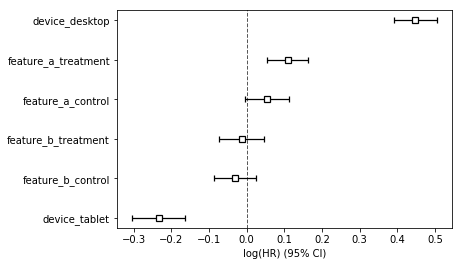

In [58]:
cph = CoxPHFitter()
cph.fit(X_train,  duration_col='duration', event_col='observed')
cph.print_summary()
cph.plot()

In [59]:
cph.check_assumptions(X_train, p_value_threshold=0.05, show_plots=False)

Proportional hazard assumption looks okay.


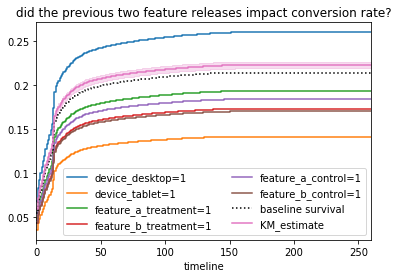

In [60]:
#plotting 1 - survival curve. This is more intuitive way to think about it and converting from hazards to survival sucks
ax = cph.plot_covariate_groups(['device_desktop', 'device_tablet'] + previous_feature_cols, values=np.eye(2 + len(previous_feature_cols)))

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(X_train['duration'], event_observed=X_train['observed'])
ax = kmf.plot(ax=ax, invert_y_axis=True)
ax.set_title('did the previous two feature releases impact conversion rate?')
ax.legend(loc=4, ncol=2)

# Tracking Progress

Text(0.5, 0, 'days from trial signup')

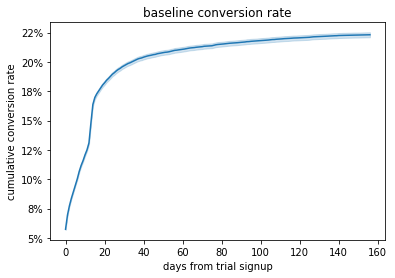

In [61]:
'''
here is the baseline conversion rate against which we are comparing our results
'''

X_train, X_test = create_regression_df(
                          df[(pd.notnull(df.device))].set_index(['cohort', 'id'])\
                            [['observed', 'duration', 'device']]\
                          ,dummy_cols=['device']\
                          ,split=True)


ax = sns.lineplot(
    data=pd.melt(
            pd.concat([
                aaf.predict_survival_function(X_test.droplevel(level=[0])).T.apply(lambda x: 1-x)
                ,df[df.id.isin(X_test.index.levels[1])].reset_index()\
                    .set_index('id')['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')).rename('cohort')
            ], axis=1, join='inner').groupby('cohort').mean().reset_index()
        ,id_vars='cohort'
        ,value_name='survival'
        ,var_name='duration'
        )
    ,x='duration'
    ,y='survival'
    ,ci='sd'
)
ax.set_title('baseline conversion rate')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_ylabel('cumulative conversion rate')
ax.set_xlabel('days from trial signup')

In [62]:
new_product_df = pd.DataFrame(connector.SheetConn('new_cohorts').sheet1.get_all_records())

#manually parsing string dates because gspread dtypes suck
sheets_date_format = '%Y-%m-%d %H:%M:%S'
new_product_df['start_dt'] = new_product_df['start_dt']\
    .apply(lambda x: datetime.strptime(x, sheets_date_format))
new_product_df['completion_dt'] = new_product_df['completion_dt']\
    .apply(lambda x: datetime.strptime(x, sheets_date_format) if x!='' else None)

#use the lifelines datetimes_to_durations function for a observed (boolean) column and a duration (time it took to subscribe)
new_product_df['duration'], new_product_df['observed'] = datetimes_to_durations(\
        new_product_df['start_dt'], new_product_df['completion_dt'], fill_date='2019-04-01')

new_product_df = new_product_df[new_product_df.cohort!=3]
new_product_df['device'].replace('', np.NaN, inplace=True)
new_product_df['browser'].replace('', np.NaN, inplace=True)

Text(0.5, 0, 'conversion rate on day 1')

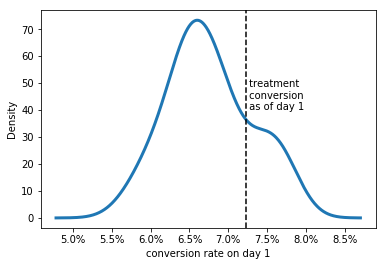

In [63]:
days_since_launch = 1
cohort_to_plot=35

cohort_conversion_to_date = (new_product_df[(new_product_df.cohort==cohort_to_plot)&\
               (new_product_df.duration<=days_since_launch)].__len__()/\
new_product_df[(new_product_df.cohort==cohort_to_plot)].__len__())

ax = (df[(df.duration<=days_since_launch)].groupby(['cohort'])['id'].count()/\
df.groupby('cohort')['id'].count()).plot(kind='density', linewidth=3)

ax.axvline(cohort_conversion_to_date, linestyle='--', color='k')
ax.text(cohort_conversion_to_date, ax.get_yticks()[5],' treatment \n conversion \n as of day {}'.format(days_since_launch), horizontalalignment='left')
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('conversion rate on day {}'.format(days_since_launch))



### Tracking our Assumptions

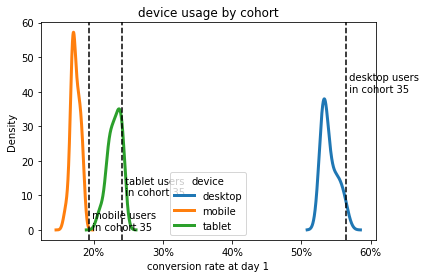

In [64]:
'''
another way to see the huge differences by device
'''
ax = pd.pivot_table(
    df.groupby(['cohort', 'device']).size().div(df.groupby('cohort').size()).reset_index()
    ,index='cohort'
    ,columns='device'
).droplevel(level=[0], axis=1).plot(kind='density', linewidth=3)

ax.set_title('device usage by cohort'.format(days_since_launch))
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('conversion rate at day {}'.format(days_since_launch))

for label, value in new_product_df[(new_product_df.cohort==cohort_to_plot)]\
                        ['device'].value_counts(normalize=True).to_dict().items():
    ax.axvline(value, linestyle='--', color='k')
    ax.text(value, ax.get_yticks()[int(value*10)], ' {} users \n in cohort {}'.format(label, cohort_to_plot), horizontalalignment='left')


Text(0.5, 0, '% of cohort using device')

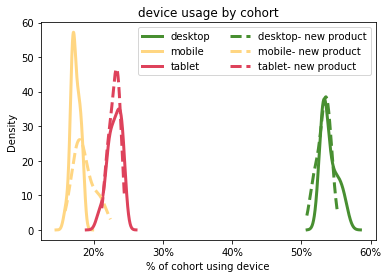

In [85]:
c = ['#488f31', '#ffd682', '#de425b']
ax = pd.pivot_table(
    df.groupby(['cohort', 'device']).size()\
        .div(df.groupby('cohort').size()).reset_index()
    ,index='cohort'
    ,columns='device'
).droplevel(level=[0], axis=1).plot(kind='density', linewidth=3, colors=c)

pd.pivot_table(
    new_product_df[new_product_df.cohort<=cohort_to_plot].groupby(['cohort', 'device']).size()\
        .div(new_product_df.groupby('cohort').size()).reset_index()
    ,index='cohort'
    ,columns='device'
).rename(columns={'desktop': 'desktop- new product', 'mobile':'mobile- new product', 'tablet':'tablet- new product'}).droplevel(level=[0], axis=1).plot(ax=ax, kind='density', linewidth=3, linestyle='--', colors=c)

ax.legend(ncol=2)


ax.set_title('device usage by cohort'.format(days_since_launch))
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('% of cohort using device'.format(days_since_launch))

In [66]:
stat, p, dof, expected = chi2_contingency(pd.concat([
    df[df.observed==True]['device'].value_counts(normalize=True).rename('control')
    ,new_product_df[new_product_df.observed==True]['device'].value_counts(normalize=True).rename('treatment')
], axis=1))

{'stat': stat, 'ppf': chi2.ppf(0.95, dof), 'is_significant': p<0.05}

{'stat': 2.4041778553940442e-05,
 'ppf': 5.991464547107979,
 'is_significant': False}

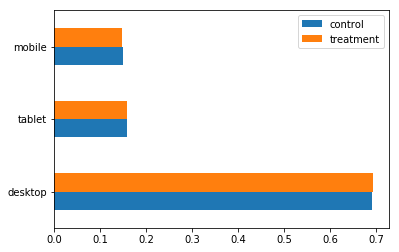

In [67]:
'''
A chi square test is just overkill at this point
'''
pd.concat([
    df[df.observed==True]['device'].value_counts(normalize=True).rename('control')
    ,new_product_df[new_product_df.observed==True]['device'].value_counts(normalize=True).rename('treatment')
], axis=1).plot(kind='barh')

### More insight with more cohorts

In [69]:
rate_at_day = 1
historical_conversion_rate_at_day = pd.pivot_table(
    df[(df.observed==True)&(df['id'].isin(X_test.index.levels[1]))]\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    .groupby(['date_label', 'duration'])['id'].count().reset_index()
    ,columns='date_label'
    ,index='duration'
).fillna(0).cumsum().T.droplevel(level=0).T.div(
    df[(df['id'].isin(X_test.index.levels[1]))]\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))\
        .groupby(['date_label'])['id'].count().T).sort_index(ascending=False, axis=1).loc[rate_at_day]

lower, upper = scipy.stats.t.interval(0.95
                                      ,len(historical_conversion_rate_at_day)-1\
                                      ,loc=np.mean(historical_conversion_rate_at_day)
                                      ,scale=scipy.stats.sem(historical_conversion_rate_at_day))


# using the training set for the population since that's the group we're comparing against
population = len(X_train)
print((upper-lower)*100, population)

#sample size calculator: https://www.surveysystem.com/sscalc.htm
sample_size_needed = 24529

df.groupby('cohort').size().cumsum().apply(lambda x: x if x<=sample_size_needed else None).dropna().nlargest(1).index[0]


0.42324425045959235 44640


11

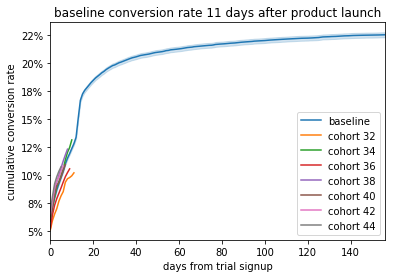

In [74]:
days_since_launch = 11

aaf.fit(X_train, 'duration', event_col='observed')

ax = sns.lineplot(
    data=pd.melt(
            pd.concat([
                aaf.predict_survival_function(X_test.droplevel(level=[0])).T.apply(lambda x: 1-x)
                ,df[df.id.isin(X_test.index.levels[1])].reset_index()\
                    .set_index('id')['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')).rename('cohort')
            ], axis=1, join='inner').groupby('cohort').mean().reset_index()
        ,id_vars='cohort'
        ,value_name='survival'
        ,var_name='duration'
        )
    ,x='duration'
    ,y='survival'
    ,ci='sd'
    ,label='baseline'
)


for i, cohort in enumerate(range(32, 45, 2)):
    (new_product_df[(new_product_df.cohort==cohort)&\
                   (new_product_df.duration<=days_since_launch-i)]\
            .groupby('duration')['id'].count().cumsum()/\
        new_product_df[new_product_df.cohort==cohort]['id'].count())\
    .plot(ax=ax, label='cohort {}'.format(cohort))



ax.set_title('baseline conversion rate {} days after product launch'.format(days_since_launch))
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_ylabel('cumulative conversion rate')
ax.set_xlabel('days from trial signup')
ax.legend()

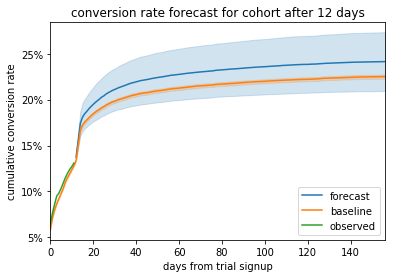

In [76]:
cohort_id = 40
at_day = 12


infected = new_product_df[(pd.notnull(new_product_df.device))&\
                    (new_product_df.cohort == cohort_id)&\
                    (new_product_df.duration<at_day)].groupby('duration')['observed'].sum().cumsum().div(
            len(new_product_df[(pd.notnull(new_product_df.device))&\
                    (new_product_df.cohort == cohort_id)]))


aaf.fit(create_regression_df(
    df[(pd.notnull(df.device))&\
                   (df.duration>=at_day)]\
        .set_index(['cohort', 'id'])[['observed', 'duration', 'device']]\
    ,dummy_cols=['device']), duration_col='duration', event_col='observed')

ax = sns.lineplot(
    data=pd.melt(
    aaf.predict_survival_function(
        create_regression_df(
            new_product_df[(pd.notnull(new_product_df.device))&\
                           (new_product_df.cohort==cohort_id)&\
                           (new_product_df.duration>at_day)]\
                .set_index(['cohort', 'id'])[['observed', 'duration', 'device']]\
        ,dummy_cols=['device']).reset_index(level=[1], drop=True)
    ).apply(lambda x: 1-x).add(infected.max()).reset_index()
        ,id_vars='index'
        ,value_name='conversion_rate'
    ).drop('variable', axis=1)
    ,x='index'
    ,y='conversion_rate'
    ,ci='sd'
    ,label='forecast'
)

aaf.fit(X_train, 'duration', event_col='observed')

sns.lineplot(
    data=pd.melt(
            pd.concat([
                aaf.predict_survival_function(X_test.droplevel(level=[0])).T.apply(lambda x: 1-x)
                ,df[df.id.isin(X_test.index.levels[1])].reset_index()\
                    .set_index('id')['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')).rename('cohort')
            ], axis=1, join='inner').groupby('cohort').mean().reset_index()
        ,id_vars='cohort'
        ,value_name='survival'
        ,var_name='duration'
        )
    ,x='duration'
    ,y='survival'
    ,ci='sd'
    ,ax=ax
    ,label='baseline'
)


infected.plot(ax=ax, label='observed')
ax.set_title('conversion rate forecast for cohort after {} days'.format(at_day))
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_ylabel('cumulative conversion rate')
ax.set_xlabel('days from trial signup')
ax.legend(loc=4)

Text(0.5, 1.0, ' as of day 21: \n new cohorts convert 1.8% more than cohorts prior to new product launch \n 95% likelihood the true lift is between -1.73% and 4.03%\n             ')

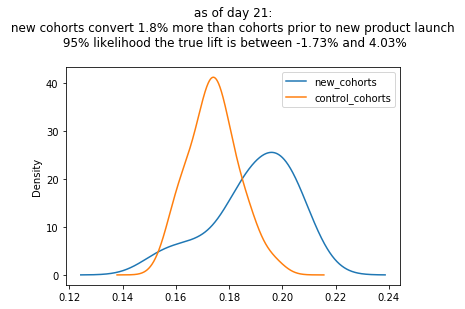

In [78]:
#assessing lift

at_day = 21
new_cohort_conversion = new_product_df[(new_product_df.duration<at_day)&(new_product_df.cohort<=32+at_day)].groupby('cohort').size()\
    .div(new_product_df.groupby('cohort').size()).reset_index(drop=True).dropna().rename('new_cohorts')
                         
control_conversions = df[df.duration<at_day].groupby('cohort').size()\
    .div(df.groupby('cohort').size()).reset_index(drop=True).dropna().rename('control_cohorts')

performance_diff = (new_cohort_conversion - control_conversions)

ax = new_cohort_conversion.plot(kind='density')
control_conversions.plot(ax=ax, kind='density')
ax.legend()

interval_size = 0.95

tail_density = (1.0 - interval_size)/2.0
lower_bound = performance_diff.quantile(0.0 + tail_density)
upper_bound = performance_diff.quantile(1.0 - tail_density)

ax.set_title(''' as of day {}: \n new cohorts convert {:.1f}% more than cohorts prior to new product launch \n {:.0f}% likelihood the true lift is between {:.2f}% and {:.2f}%
             '''
                 .format(at_day, performance_diff.mean()*100, interval_size*100, lower_bound*100, upper_bound*100))


Text(0.5, 1.0, 'new cohorts convert 2.0% more than cohorts prior to new product launch \n\n                95% likelihood the true lift is between -1.98% and 4.57%\n             ')

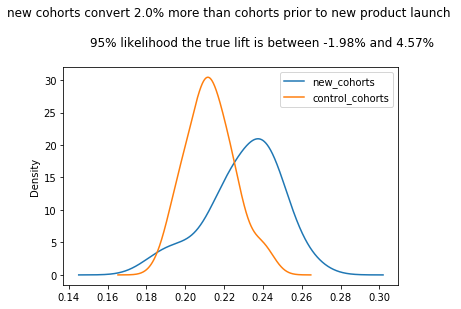

In [79]:
#assessing lift

at_day = 180
new_cohort_conversion = new_product_df[(new_product_df.duration<at_day)&\
                                       (new_product_df.cohort<=32+at_day)].groupby('cohort').size()\
    .div(new_product_df.groupby('cohort').size()).reset_index(drop=True).dropna().rename('new_cohorts')
                         
control_conversions = df[df.duration<at_day].groupby('cohort').size()\
    .div(df.groupby('cohort').size()).reset_index(drop=True).dropna().rename('control_cohorts')

performance_diff = (new_cohort_conversion - control_conversions)

ax = new_cohort_conversion.plot(kind='density')
control_conversions.plot(ax=ax, kind='density')
ax.legend()

interval_size = 0.95

tail_density = (1.0 - interval_size)/2.0
lower_bound = performance_diff.quantile(0.0 + tail_density)
upper_bound = performance_diff.quantile(1.0 - tail_density)

ax.set_title('''new cohorts convert {:.1f}% more than cohorts prior to new product launch \n
                {:.0f}% likelihood the true lift is between {:.2f}% and {:.2f}%
             '''
                 .format(performance_diff.mean()*100, interval_size*100, lower_bound*100, upper_bound*100))
